In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf 

import os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

In [2]:
image_dir = Path('/content/drive/MyDrive/mini project/Snake Images')

# Get filepaths and labels
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [3]:
image_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/mini project/Snake Imag...,Non Venomous
1,/content/drive/MyDrive/mini project/Snake Imag...,Non Venomous
2,/content/drive/MyDrive/mini project/Snake Imag...,Non Venomous
3,/content/drive/MyDrive/mini project/Snake Imag...,Non Venomous
4,/content/drive/MyDrive/mini project/Snake Imag...,Non Venomous


In [4]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/content/drive/MyDrive/mini project/Snake Imag...,Non Venomous
1,/content/drive/MyDrive/mini project/Snake Imag...,Non Venomous
2,/content/drive/MyDrive/mini project/Snake Imag...,Non Venomous
3,/content/drive/MyDrive/mini project/Snake Imag...,Non Venomous
4,/content/drive/MyDrive/mini project/Snake Imag...,Non Venomous


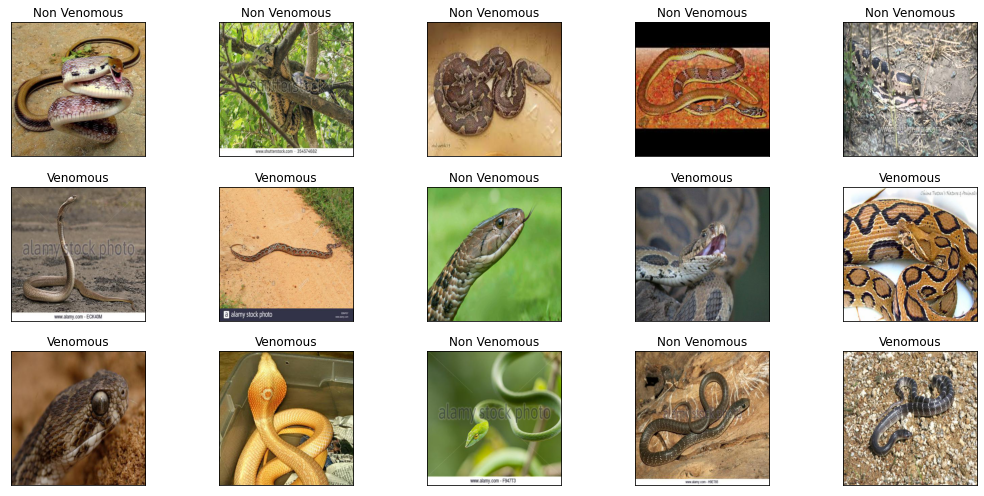

In [5]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)


In [7]:
train_df.shape

(1749, 2)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_df.head(5)

,Filepath,Label
1836,/content/drive/MyDrive/mini project/Snake Imag...,Venomous
1821,/content/drive/MyDrive/mini project/Snake Imag...,Venomous
1301,/content/drive/MyDrive/mini project/Snake Imag...,Venomous
1753,/content/drive/MyDrive/mini project/Snake Imag...,Non Venomous
8,/content/drive/MyDrive/mini project/Snake Imag...,Venomous


In [10]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1400 validated image filenames belonging to 2 classes.
Found 349 validated image filenames belonging to 2 classes.
Found 195 validated image filenames belonging to 2 classes.


In [11]:
test_images

In [12]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=2)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(2, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [13]:
K.clear_session()

model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]

27018416/27018416 [==============================] - 1s 0us/step


In [14]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)


In [15]:
checkpoint_path = 'models/EfficientNetB1/model_224.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]

In [27]:
train_images

In [16]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
44/44 [==============================] - ETA: 0s - loss: 0.5068 - accuracy: 0.7421 - auc: 0.8177
Epoch 1: val_loss improved from inf to 1.61022, saving model to models/EfficientNetB1/model_224.h5
44/44 [==============================] - 570s 13s/step - loss: 0.5068 - accuracy: 0.7421 - auc: 0.8177 - val_loss: 1.6102 - val_accuracy: 0.4069 - val_auc: 0.4032 - lr: 0.0010
Epoch 2/25
44/44 [==============================] - ETA: 0s - loss: 0.2932 - accuracy: 0.8679 - auc: 0.9442
Epoch 2: val_loss improved from 1.61022 to 0.82343, saving model to models/EfficientNetB1/model_224.h5
44/44 [==============================] - 23s 509ms/step - loss: 0.2932 - accuracy: 0.8679 - auc: 0.9442 - val_loss: 0.8234 - val_accuracy: 0.4069 - val_auc: 0.4215 - lr: 0.0010
Epoch 3/25
44/44 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9571 - auc: 0.9891
Epoch 3: val_loss did not improve from 0.82343
44/44 [==============================] - 22s 498ms/step - loss: 0.1248 - a

In [17]:
model.save("/content/drive/MyDrive/mini project/modelnew.h5")

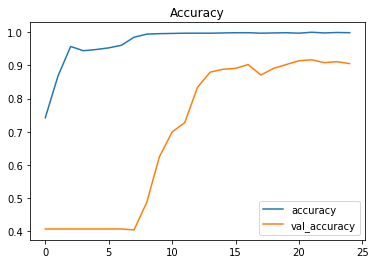

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [20]:
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.36826
Test Accuracy: 90.26%


In [21]:
test_images

In [22]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

7/7 [==============================] - 4s 153ms/step
The first 5 predictions: ['Venomous', 'Non Venomous', 'Non Venomous', 'Venomous', 'Non Venomous']


['Venomous',
 'Non Venomous',
 'Non Venomous',
 'Venomous',
 'Non Venomous',
 'Non Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Non Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Non Venomous',
 'Non Venomous',
 'Non Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Non Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Non Venomous',
 'Non Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Non Venomous',
 'Venomous',
 'Non Venomous',
 'Non Venomous',
 'Venomous',
 'Venomous',
 'Non Venomous',
 'Venomous',
 'Non Venomous',
 'Venomous',
 'Non Venomous',
 'Non Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Non Venomous',
 'Venomous',
 'Non Venomous',
 'Venomous',
 'Non Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Venomous',
 'Non Venomous',
 'Venomous',
 '

In [41]:
image_dir = Path('/content/drive/MyDrive/SNAKE_TEST/Snake Images/valid')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
valid_df = pd.concat([filepaths, labels], axis=1)

In [42]:
test = test_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1 validated image filenames belonging to 1 classes.


In [43]:
pred = model.predict(test)
pred = np.argmax(pred,axis=1)


1/1 [==============================] - 0s 67ms/step


In [44]:
if pred[0]==1:
  print("venomous")
else:
  print("non venomous")

venomous
